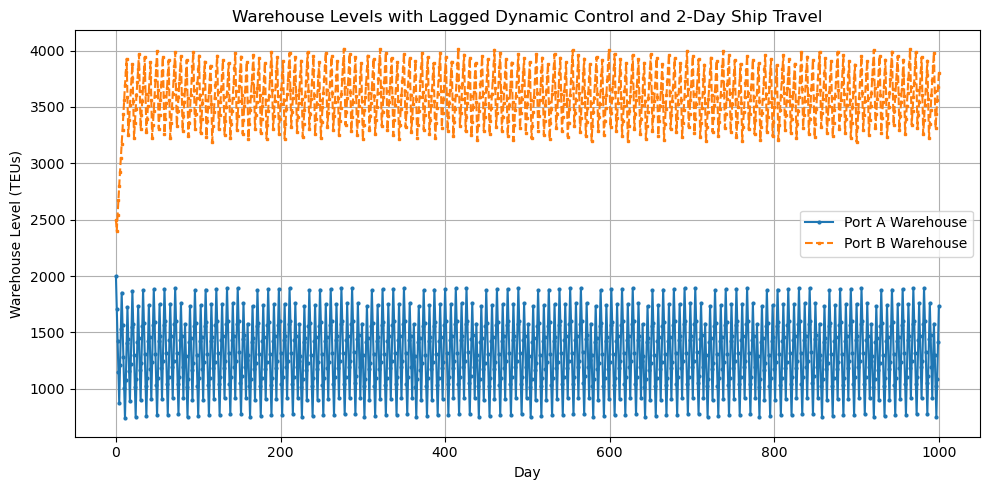

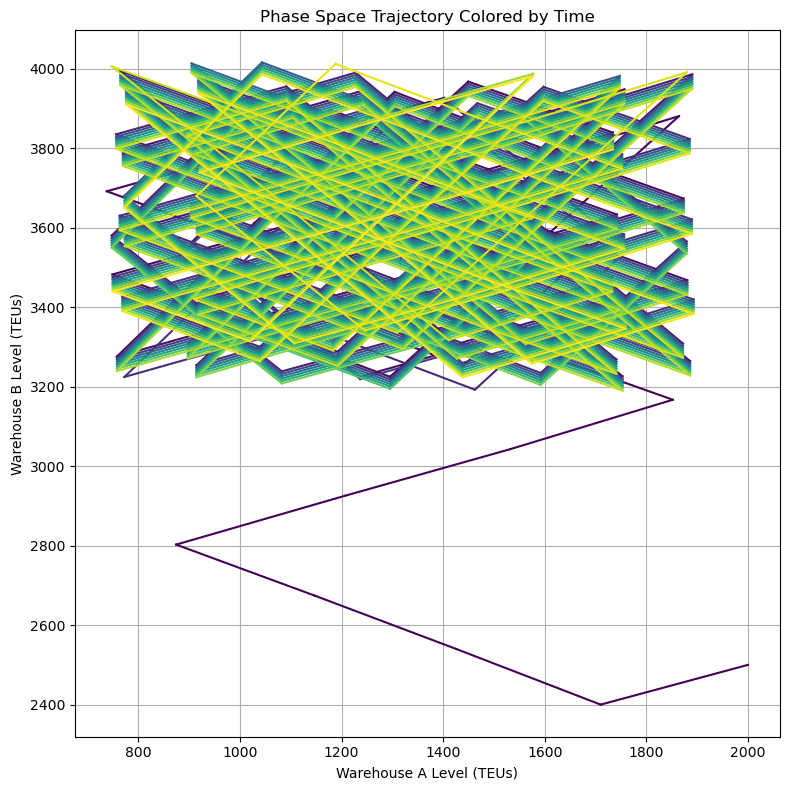

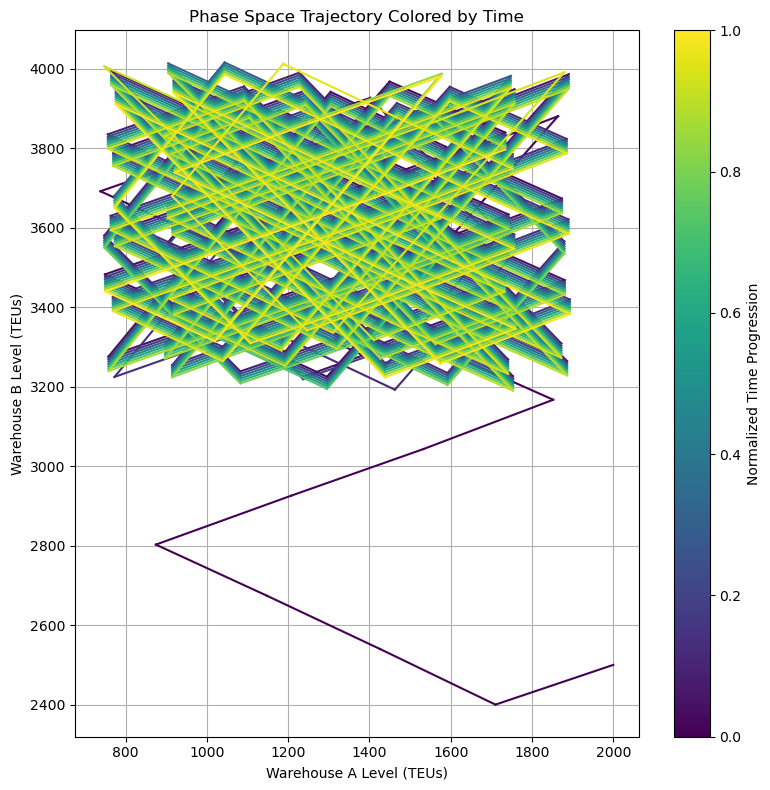

Port A average level (last 100 days): 1309.2 TEUs, oscillation range: 1145.7 TEUs
Port B average level (last 100 days): 3618.4 TEUs, oscillation range: 788.8 TEUs


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Parameters
ship_capacity_base = 200
warehouse_capacity = 5000

base_inflow_A = 150
base_outflow_A = 200
base_inflow_B = 130
base_outflow_B = 230

inflow_boost = 5.0
inflow_penalty = 0.1
outflow_boost = 2.5

time_steps = 1000
x0 = 2000
y0 = 2500

control_lag = 2
delay_buffer_A = [x0] * control_lag
delay_buffer_B = [y0] * control_lag

in_transit_cargo = 0
warehouse_A = [x0]
warehouse_B = [y0]

# Simulation loop
for t in range(time_steps):
    x = warehouse_A[-1]
    y = warehouse_B[-1]

    x_delay = delay_buffer_A[-control_lag]
    y_delay = delay_buffer_B[-control_lag]

    # Port A control logic
    if x_delay < 0.25 * warehouse_capacity:
        inflow_A = base_inflow_A * inflow_boost
        outflow_A = base_outflow_A
    elif x_delay > 0.75 * warehouse_capacity:
        inflow_A = base_inflow_A * inflow_penalty
        outflow_A = base_outflow_A * outflow_boost
    else:
        inflow_A = base_inflow_A
        outflow_A = base_outflow_A

    # Port B control logic
    if y_delay < 0.25 * warehouse_capacity:
        inflow_B = base_inflow_B * inflow_boost
        outflow_B = base_outflow_B
    elif y_delay > 0.75 * warehouse_capacity:
        inflow_B = base_inflow_B * inflow_penalty
        outflow_B = base_outflow_B * outflow_boost
    else:
        inflow_B = base_inflow_B
        outflow_B = base_outflow_B

    # Ship movement and cargo transfer
    new_y = warehouse_B[-1] + in_transit_cargo
    in_transit_cargo = 0

    effective_ship_capacity = ship_capacity_base * (1 + 0.5 * (x / warehouse_capacity))
    ship_pickup = min(x, effective_ship_capacity)
    ship_delivery = min(ship_pickup, warehouse_capacity - new_y)

    ship_pickup = ship_delivery
    in_transit_cargo = ship_pickup

    # Warehouse updates
    new_x = x - ship_pickup + inflow_A - outflow_A
    new_y = new_y + inflow_B - outflow_B

    new_x = np.clip(new_x, 0, warehouse_capacity)
    new_y = np.clip(new_y, 0, warehouse_capacity)

    warehouse_A.append(new_x)
    warehouse_B.append(new_y)

    delay_buffer_A.append(new_x)
    delay_buffer_B.append(new_y)

# Time series plot
warehouse_A = np.array(warehouse_A)
warehouse_B = np.array(warehouse_B)

plt.figure(figsize=(10, 5))
plt.plot(warehouse_A, label="Port A", marker='o', linestyle='-', markersize=2)
plt.plot(warehouse_B, label="Port B", marker='s', linestyle='--', markersize=2)
plt.title('Warehouse Levels Over Time')
plt.xlabel('Day')
plt.ylabel('Warehouse Level (TEUs)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Phase space plot
t = np.linspace(0, 1, len(warehouse_A))
cmap = cm.viridis

plt.figure(figsize=(8, 8))
for i in range(len(warehouse_A) - 1):
    plt.plot(warehouse_A[i:i+2], warehouse_B[i:i+2], color=cmap(t[i]), linewidth=1.5)

plt.title('Phase Space Trajectory')
plt.xlabel('Warehouse A')
plt.ylabel('Warehouse B')
plt.grid(True)
plt.tight_layout()

# Phase space with colorbar
fig, ax = plt.subplots(figsize=(8, 8))
for i in range(len(warehouse_A) - 1):
    ax.plot(warehouse_A[i:i+2], warehouse_B[i:i+2], color=cmap(t[i]), linewidth=1.5)

ax.set_title('Phase Space Trajectory (Colored by Time)')
ax.set_xlabel('Warehouse A')
ax.set_ylabel('Warehouse B')
ax.grid(True)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Normalized Time')

plt.tight_layout()
plt.show()

# Summary statistics
N = 100
final_A = warehouse_A[-N:]
final_B = warehouse_B[-N:]

mean_A = np.mean(final_A)
mean_B = np.mean(final_B)
range_A = np.max(final_A) - np.min(final_A)
range_B = np.max(final_B) - np.min(final_B)

print(f"Port A average (last {N} days): {mean_A:.1f} TEUs, range: {range_A:.1f}")
print(f"Port B average (last {N} days): {mean_B:.1f} TEUs, range: {range_B:.1f}")


Lyapunov Exponent Estimate: -0.0104


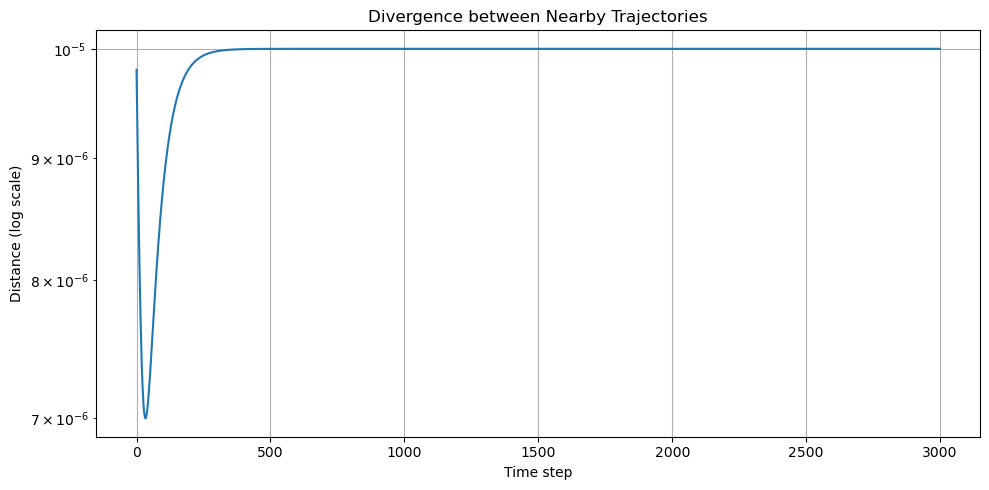

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
ship_capacity_base = 200
warehouse_capacity = 5000
base_inflow_A = 150
base_outflow_A = 200
base_inflow_B = 130
base_outflow_B = 230
inflow_boost = 5.0
inflow_penalty = 0.1
outflow_boost = 2.5
control_lag = 2
time_steps = 3000

# Initial conditions and small perturbation
x0 = 2000
y0 = 2500
delta = 1e-5  # initial separation

# Trajectory storage
traj1_A = [x0]
traj1_B = [y0]
traj2_A = [x0 + delta]
traj2_B = [y0]

# Transit and lag buffers
in_transit_cargo1 = 0
in_transit_cargo2 = 0
delay1_A = [x0] * control_lag
delay1_B = [y0] * control_lag
delay2_A = [x0 + delta] * control_lag
delay2_B = [y0] * control_lag

# Distance tracker
distances = []

for t in range(time_steps):
    x1, y1 = traj1_A[-1], traj1_B[-1]
    x2, y2 = traj2_A[-1], traj2_B[-1]

    x1_delay = delay1_A[-control_lag]
    y1_delay = delay1_B[-control_lag]
    x2_delay = delay2_A[-control_lag]
    y2_delay = delay2_B[-control_lag]

    # Control logic (identical for both trajectories)
    def control(x_delay, y_delay):
        if x_delay < 0.25 * warehouse_capacity:
            inflow_A = base_inflow_A * inflow_boost
            outflow_A = base_outflow_A
        elif x_delay > 0.75 * warehouse_capacity:
            inflow_A = base_inflow_A * inflow_penalty
            outflow_A = base_outflow_A * outflow_boost
        else:
            inflow_A = base_inflow_A
            outflow_A = base_outflow_A

        if y_delay < 0.25 * warehouse_capacity:
            inflow_B = base_inflow_B * inflow_boost
            outflow_B = base_outflow_B
        elif y_delay > 0.75 * warehouse_capacity:
            inflow_B = base_inflow_B * inflow_penalty
            outflow_B = base_outflow_B * outflow_boost
        else:
            inflow_B = base_inflow_B
            outflow_B = base_outflow_B

        return inflow_A, outflow_A, inflow_B, outflow_B

    inflow_A1, outflow_A1, inflow_B1, outflow_B1 = control(x1_delay, y1_delay)
    inflow_A2, outflow_A2, inflow_B2, outflow_B2 = control(x2_delay, y2_delay)

    # Update trajectory 1
    new_y1 = y1 + in_transit_cargo1
    in_transit_cargo1 = 0
    effective_ship1 = ship_capacity_base * (1 + 0.5 * (x1 / warehouse_capacity))
    ship_pickup1 = min(x1, effective_ship1)
    ship_delivery1 = min(ship_pickup1, warehouse_capacity - new_y1)
    in_transit_cargo1 = ship_delivery1
    new_x1 = x1 - ship_delivery1 + inflow_A1 - outflow_A1
    new_y1 = new_y1 + inflow_B1 - outflow_B1
    new_x1 = np.clip(new_x1, 0, warehouse_capacity)
    new_y1 = np.clip(new_y1, 0, warehouse_capacity)

    traj1_A.append(new_x1)
    traj1_B.append(new_y1)
    delay1_A.append(new_x1)
    delay1_B.append(new_y1)

    # Update trajectory 2
    new_y2 = y2 + in_transit_cargo2
    in_transit_cargo2 = 0
    effective_ship2 = ship_capacity_base * (1 + 0.5 * (x2 / warehouse_capacity))
    ship_pickup2 = min(x2, effective_ship2)
    ship_delivery2 = min(ship_pickup2, warehouse_capacity - new_y2)
    in_transit_cargo2 = ship_delivery2
    new_x2 = x2 - ship_delivery2 + inflow_A2 - outflow_A2
    new_y2 = new_y2 + inflow_B2 - outflow_B2
    new_x2 = np.clip(new_x2, 0, warehouse_capacity)
    new_y2 = np.clip(new_y2, 0, warehouse_capacity)

    traj2_A.append(new_x2)
    traj2_B.append(new_y2)
    delay2_A.append(new_x2)
    delay2_B.append(new_y2)

    # Distance between trajectories
    d = np.sqrt((new_x1 - new_x2)**2 + (new_y1 - new_y2)**2)
    distances.append(d)

# Lyapunov exponent estimation
distances = np.array(distances)
positive_distances = distances[distances > 0]
lyapunov_estimate = np.mean(np.log(positive_distances / delta))

print(f"Lyapunov Exponent Estimate: {lyapunov_estimate:.4f}")

# Plot divergence
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.yscale('log')
plt.title('Divergence Between Nearby Trajectories')
plt.xlabel('Time Step')
plt.ylabel('Distance (log scale)')
plt.grid(True)
plt.tight_layout()
plt.show()
